<a href="https://colab.research.google.com/github/MEKSAAA/TJSSE-Intro-to-AI/blob/main/MNIST_handwriting_digits_junwenmiao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MNIST手写数字识别**

导入所需的库和模块，并打印TensorFlow的版本号。

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
import IPython.display as display
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.15.0


定义全局变量，设置训练所需的参数，指定训练和测试数据集的文件路径。

BATCH_SIZE 是全局批处理大小，即每次模型训练时一次输入模型的样本数量。

EPOCHS 是训练的轮数，即整个训练数据集被遍历的次数。在每个epoch中，模型会使用训练数据进行参数更新。

LEARNING_RATE 是学习率，即控制模型参数更新幅度的大小。学习率越高，模型参数更新得越快，但可能会导致不稳定性；学习率越低，模型更新越稳定，但收敛速度较慢。

training_images_file, training_labels_file, validation_images_file, validation_labels_file: 这些是训练和验证数据集的文件路径，它们指定了训练和验证数据在文件系统中的位置。这些路径使用了Google Cloud Storage（GCS）的协议前缀gs://，表明这些数据集存储在Google云存储中。这里包含了训练图像、训练标签、验证图像和验证标签的文件路径。

In [ ]:
BATCH_SIZE = 64 # Gobal batch size.
EPOCHS = 10
LEARNING_RATE = 0.01

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

定义可视化的辅助函数和配置，用于展示模型训练过程中的指标和结果。

plt.rc: 这里设置了Matplotlib的一些默认配置，包括图像、网格、坐标轴等。这些设置会影响到后续的图表展示。

dataset_to_numpy_util: 这个函数用于将TensorFlow数据集转换为NumPy数组，以便于后续处理和可视化。它从训练和验证数据集中提取出指定数量的图像和标签，并返回它们的NumPy数组表示。

create_digits_from_local_fonts: 这个函数用于从本地字体文件中创建数字图像，用于测试和可视化。它创建了一张包含多个数字的图像，并返回图像的NumPy数组表示以及对应的标签。

display_digits: 这个函数用于显示一行数字图像，并在图像上标注出模型的预测结果和实际标签。如果预测结果与实际标签不一致，标注的数字会显示为红色。

display_top_unrecognized: 这个函数用于按照模型对数字的识别结果进行排序，然后显示多行数字图像。未正确识别的数字会排在前面，显示为红色。

plot_learning_rate: 这个函数用于绘制学习率的变化情况。它接受一个学习率函数和训练的轮数作为参数，并绘制学习率随着训练轮数变化的曲线图。

PlotTraining: 这是一个自定义的Keras回调函数，用于在训练过程中动态地绘制训练指标（如损失函数值、准确率等）的变化情况。它在每个batch和每个epoch结束时记录并绘制指标的变化曲线。

In [ ]:
#@title Visualization Utilities

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets.
def dataset_to_numpy_util(training_dataset, validation_dataset, N):

  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.apply(tf.data.experimental.unbatch()).batch(N)

  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break

  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])

  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)

  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)

# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, steps_per_epoch, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = steps_per_epoch

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()

    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)

    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

  def on_train_end(self, logs={}):
    display.clear_output(wait=True)

    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)

    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)

    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

定义用于数据处理的辅助函数，它们用于加载、解析和预处理数据集，为了方便地处理MNIST数据集的加载和预处理，并将数据集转换为适合模型训练的格式。

read_label(tf_bytestring): 这个函数用于解析标签数据。它将输入的TensorFlow字节字符串解码为uint8类型的张量，并将标签进行独热编码（one-hot encoding）以适应模型的输出格式。

read_image(tf_bytestring): 这个函数用于解析图像数据。它将输入的TensorFlow字节字符串解码为uint8类型的张量，并将像素值缩放到0到1之间的浮点数范围内。

load_dataset(image_file, label_file): 这个函数用于加载图像和标签数据集。它通过FixedLengthRecordDataset从文件中读取图像和标签数据，并使用map函数将字节字符串解析为图像和标签。

get_training_dataset(image_file, label_file, batch_size): 这个函数用于获取训练数据集。它加载图像和标签数据集，然后进行缓存、打乱、重复、批处理等操作，并返回训练数据集对象。

get_validation_dataset(image_file, label_file): 这个函数用于获取验证数据集。它加载图像和标签数据集，进行缓存和批处理操作，并返回验证数据集对象。

In [ ]:
#@title Data Processing Utilities

def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label

def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image

def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset

def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset

def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

定义用于模型编译和训练的辅助函数，以方便地在不同的硬件加速器上编译和训练模型，以及记录训练过程中的指标变化情况。

set_strategy(accelerator): 这个函数用于设置分布式策略（distribution strategy），以便在不同的硬件加速器（TPU、GPU、CPU）上运行模型。它根据输入的加速器类型来选择合适的策略，并返回相应的策略对象。

compile(model): 这个函数用于编译模型。它使用Adam优化器，交叉熵损失函数，并设置了准确率作为评估指标。

train(model, strategy, epochs=EPOCHS, batch_size=BATCH_SIZE): 这个函数用于训练模型。它接受模型、分布式策略对象、训练轮数和批处理大小作为参数，并在训练过程中使用指定的策略对模型进行训练。

In [ ]:
#@title Training Utilities

def set_strategy(accelerator):
  strategy = None
  if accelerator == 'tpu':
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    print('TPU initialized: ', tpu.cluster_spec().as_dict()['worker'])
  elif accelerator == 'gpu':
    gpus = tf.config.experimental.list_logical_devices("GPU")
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
  else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')
  print("Number of accelerators: ", strategy.num_replicas_in_sync)

  batch_size = BATCH_SIZE*strategy.num_replicas_in_sync
  LEARNING_RATE_EXP_DECAY = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
  # Learning rate computed later as LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch
  # 0.7 decay instead of 0.6 means a slower decay, i.e. a faster learnign rate.
  # set up learning rate decay
  lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)
  training_dataset = get_training_dataset(training_images_file, training_labels_file, batch_size)
  validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)
  return (strategy, batch_size, lr_decay, training_dataset, validation_dataset)

def compile(model):
  model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return

def train(model, strategy, epochs=EPOCHS, batch_size=BATCH_SIZE):
  steps_per_epoch = 60000 // batch_size  # 60,000 items in this dataset
  print("steps_per_epoch=", steps_per_epoch)

  plot_training = PlotTraining(steps_per_epoch, sample_rate=1, zoom=1)
  history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch,
                      epochs=EPOCHS, callbacks=[lr_decay, plot_training])

  final_stats = model.evaluate(validation_dataset, steps=1)
  print("Validation accuracy: ", final_stats[1])

设置分布式策略、加载训练和验证数据集，并可视化一些数据样本，有助于了解数据的特点和质量，以及模型在不同数据集上的表现。

set_strategy('cpu'): 这一行调用了set_strategy函数，传入了参数'cpu'，表示使用CPU进行模型训练。set_strategy函数会根据输入的加速器类型设置合适的分布式策略，并返回相关的参数。

N = 24: 这一行定义了一个变量N，表示要展示的数字样本数量。

(training_digits, training_labels, validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N): 这一行调用了dataset_to_numpy_util函数，将训练和验证数据集转换为NumPy数组，并获取了指定数量的训练和验证数字样本及其标签。

display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N): 这一行调用了display_digits函数，用于展示训练数据集中的数字样本及其标签。它会显示一行数字图像，每个图像下方标注其对应的标签。

display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N): 这一行调用了display_digits函数，用于展示验证数据集中的数字样本及其标签。它会显示一行数字图像，每个图像下方标注其对应的标签。

font_digits, font_labels = create_digits_from_local_fonts(N): 这一行调用了create_digits_from_local_fonts函数，生成了一些来自本地字体文件的数字样本。这些样本通常用于测试和可视化模型的效果。

Running on CPU
Number of accelerators:  1


Instructions for updating:
Use `tf.data.Dataset.unbatch()`.


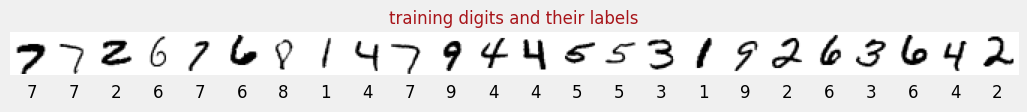

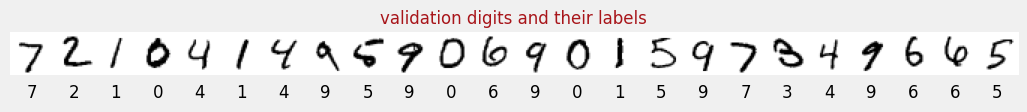

In [ ]:
(strategy, batch_size, lr_decay, training_dataset, validation_dataset) = set_strategy('cpu')
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

在首次尝试构建识别手写数字的神经网络时，我们使用了能想象到的最简单的网络。它只有两层，一层是每个输入像素都有一个节点，然后是一个密集层（即与所有第一层节点完全连接），该层使用 softmax 激活函数，为十个给定类别中的每个类别生成输出概率，代表数字 0 到 9。
完成对MNIST数据集的简单数字识别任务，并观察模型的训练效果以及对新样本的识别能力。

使用set_strategy函数设置了分布式策略，指定了在CPU上进行模型训练，并返回了相关的参数。

使用strategy.scope()将模型构建和训练的过程放在了分布式策略的作用域内，以便利用CPU进行训练。

使用tf.keras.Sequential构建了一个简单的全连接神经网络模型，包含一个输入层和一个输出层。输入层的形状是28*28，输出层包含10个节点，使用softmax激活函数进行多类别分类。

使用compile函数编译了模型，指定了优化器、损失函数和评估指标。

打印了模型的摘要信息，包括模型的结构和参数数量。

使用train函数训练了模型，包括了训练数据集的加载、模型的训练和评估。

使用训练好的模型对来自本地字体文件的数字样本进行识别，并展示了识别结果。

使用训练好的模型对验证数据集中的数字样本进行识别，并展示了识别结果中未正确识别的样本。

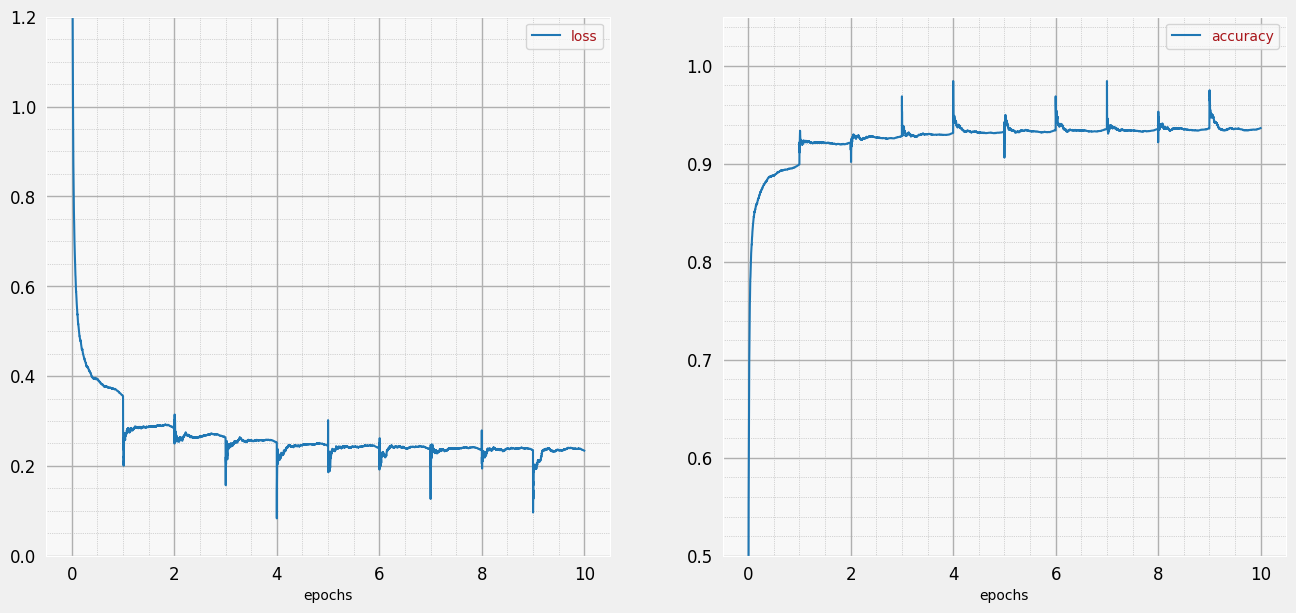

1/1 [==============================] - 1s 901ms/step - loss: 0.2637 - accuracy: 0.9279
Validation accuracy:  0.9279000163078308
1/1 [==============================] - 0s 78ms/step


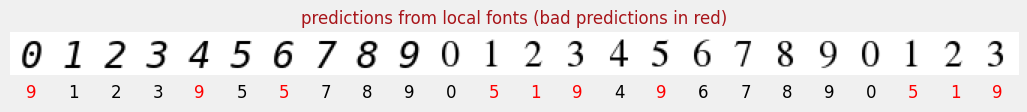

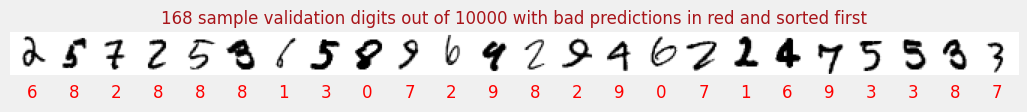

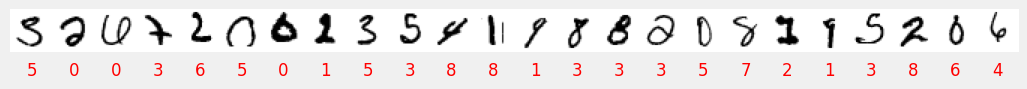

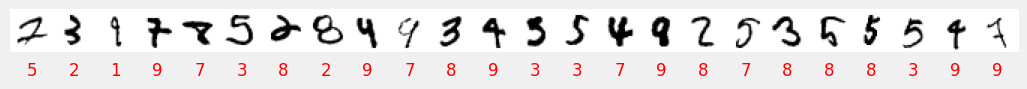

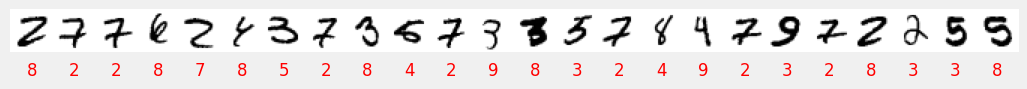

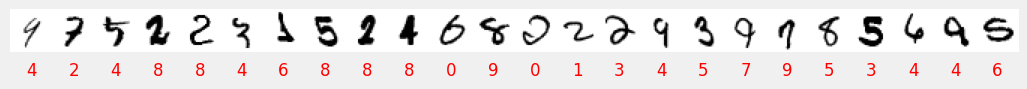

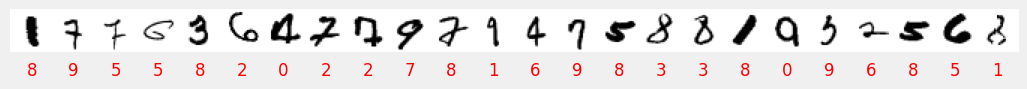

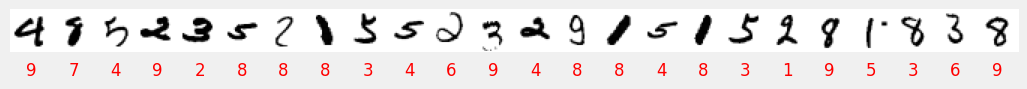

In [ ]:
(strategy, batch_size, lr_decay, training_dataset, validation_dataset) = set_strategy('cpu')

with strategy.scope():
  model = tf.keras.Sequential(
  [
    tf.keras.layers.Input(shape=(28*28,)),
    tf.keras.layers.Dense(10, activation='softmax')
  ])
  compile(model)

model.summary()
train(model, strategy)

# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

tf.keras.layers.Reshape: 这一层用于将输入数据重塑为指定的形状。在这里，将输入形状从一维的28*28重塑为二维的28x28x1，即图像形状。

三个卷积层（tf.keras.layers.Conv2D）：这些层用于提取图像特征。每个卷积层都包括一个卷积操作和一个激活函数。卷积操作用于在图像上滑动一个卷积核来提取特征，激活函数则引入了非线性特性。这些层逐渐增加了卷积核的数量和图像的尺寸，以便提取更高级别的特征。

两个全连接层（tf.keras.layers.Dense）：这些层用于将卷积层提取的特征映射到类别标签。第一个全连接层包含200个节点，并使用了ReLU激活函数。第二个全连接层则输出10个节点，对应于数据集中的10个类别，并使用了softmax激活函数进行多类别分类。

tf.keras.layers.BatchNormalization：这些层用于进行批标准化操作，有助于加速训练过程并增强模型的稳定性。批标准化在每个批次中对数据进行归一化，并学习适当的缩放和平移参数。

tf.keras.layers.Dropout：这一层用于在训练过程中随机丢弃部分节点，以防止模型过拟合。

In [ ]:
def make_model():
 return tf.keras.Sequential(
  [
    tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1), name="image"),

    tf.keras.layers.Conv2D(filters=12, kernel_size=3, padding='same', use_bias=False), # no bias necessary before batch norm
    tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
    tf.keras.layers.Activation('relu'), # activation after batch norm

    tf.keras.layers.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
    tf.keras.layers.BatchNormalization(scale=False, center=True),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(filters=32, kernel_size=6, padding='same', use_bias=False, strides=2),
    tf.keras.layers.BatchNormalization(scale=False, center=True),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, use_bias=False),
    tf.keras.layers.BatchNormalization(scale=False, center=True),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.4), # Dropout on dense layer only

    tf.keras.layers.Dense(10, activation='softmax')
  ])

使用set_strategy('gpu')函数设置了在GPU上进行模型训练的分布式策略，并返回了相关参数。
在分布式策略的作用域内，使用make_model()函数构建了一个复杂的卷积神经网络模型，并通过compile函数编译了模型。

打印了模型的摘要信息，包括模型的结构和参数数量。

调用train函数训练了模型，包括加载训练数据集、模型的训练和评估。需要注意的是，这里将batch_size作为参数传递给了train函数。

使用训练好的模型对来自本地字体文件的数字样本进行识别，并展示了识别结果。
使用训练好的模型对验证数据集中的数字样本进行识别，并展示了未正确识别的样本。

通过这段代码，你可以在GPU上训练一个复杂的卷积神经网络模型来进行数字识别任务，并观察模型的训练效果以及对新样本的识别能力。


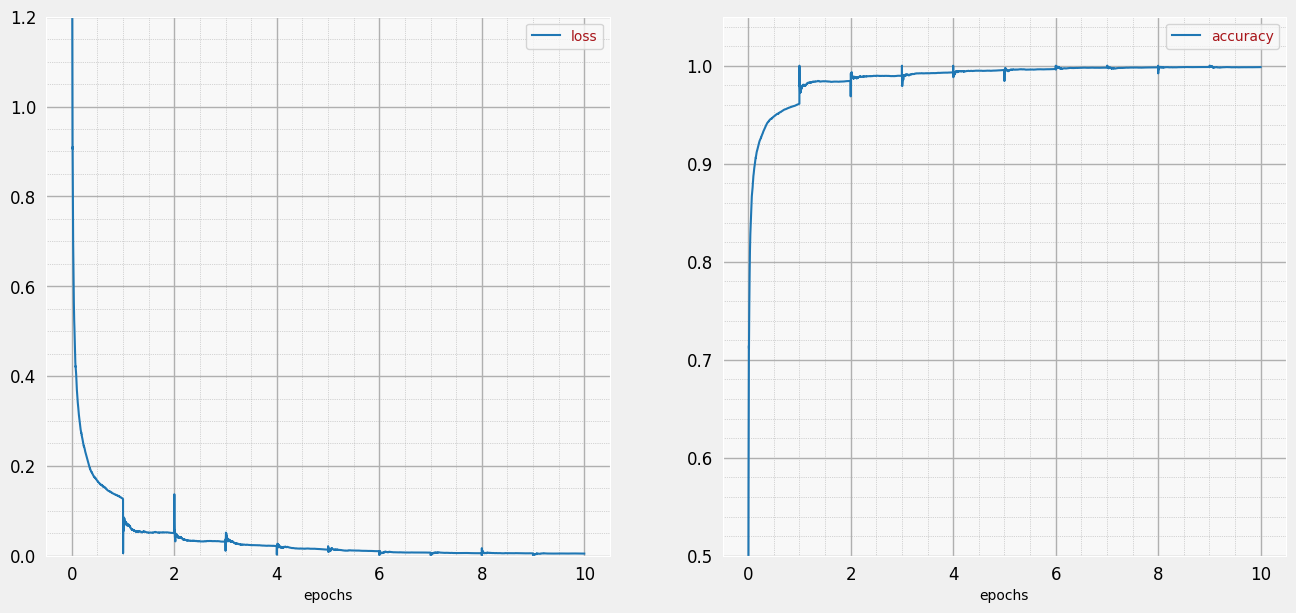

1/1 [==============================] - 3s 3s/step - loss: 0.0167 - accuracy: 0.9952
Validation accuracy:  0.995199978351593
1/1 [==============================] - 0s 137ms/step


In [ ]:
(strategy, batch_size, lr_decay, training_dataset, validation_dataset) = set_strategy('cpu')

with strategy.scope():
  model = make_model()
  compile(model)
model.summary()
train(model, strategy)

# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)